# Analyzing the results for `sciplex_hparam`

This is preliminary to the `fintuning_num_genes` and `finetuning_OOD_prediction` experiments. We look at the results of sweeping the optimisation related hyperparameters for fine-tuning on the sciplex dataset for all other embeddings.

In [1]:
from pathlib import Path
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import seml
from matplotlib import pyplot as plt

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_context("poster")
pd.set_option('display.max_columns', 100)

In [2]:
results = seml.get_results(
    "sciplex_hparam",
    to_data_frame=True,
    fields=["config", "result", "seml", "config_hash"],
    states=["COMPLETED"],
)

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

/home/simon/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [3]:
# filter out the non-relevant rdkit runs
results = results[(results["config.model.hparams.dim"] == 32)]
results["config.model.embedding.model"].value_counts()

rdkit          20
grover_base    14
jtvae          14
MPNN            8
Name: config.model.embedding.model, dtype: int64

In [4]:
results.loc[:, [c for c in results.columns if 'disentanglement' in c]]

,result.perturbation disentanglement,result.covariate disentanglement
0,[0.02395700290799141],[[0.7632986903190613]]
1,[0.023617437109351158],[[0.9189021587371826]]
2,[0.024413662031292915],[[0.7295176982879639]]
3,[0.02581876516342163],[[0.8676275610923767]]
4,[0.02321932464838028],[[0.6091355085372925]]
5,[0.023172488436102867],[[0.6039366126060486]]
6,[0.023149069398641586],[[0.5006381273269653]]
7,[0.023125650361180305],[[0.8520309329032898]]
8,[0.02313736081123352],[[0.8027821183204651]]
9,[0.024472208693623543],[[0.8501574993133545]]


In [5]:
good_disentanglement = results['result.perturbation disentanglement'].apply(lambda x: x[0]) < 0.2

In [6]:
results.loc[good_disentanglement, [c for c in results.columns if 'result' in c]]

,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[195],"[1336.0160297362454, -9812.380385041237, -1035...","[39476.329177856445, 39404.3604927063, 39388.7...","[7848.349210202694, 7873.91974067688, 7867.942...","[1.1288760321040172, 0.13257947063357278, 0.06...","[0.01827551887458867, 0.003706794678407732, 0....",369.965325,"[[0.9356309134591531, 0.655880999396072, 0.916...","[[0.8446647344063235, 0.8521980465533168, 0.73...","[[0.8950010287134271, 0.7985896468162537, 0.86...",[0.02395700290799141],[0.022996850227743757],[[0.7632986903190613]],[[0.3333333333333333]],195
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[90],"[-2161.7397191289347, -4957.599641842768, -530...","[19685.989889144897, 19670.996384620667, 19671...","[3925.918530225754, 3925.6900311112404, 3925.7...","[0.06451398820388984, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0003211629885351841, 0.0, 0.0, 0.0, 0.0, 0....",111.582821,"[[0.5568742746349223, 0.3502557209785772, 0.66...","[[0.5155377848469104, 0.5759471994112114, 0.53...","[[0.5241898622429162, 0.5324907041432565, 0.62...",[0.023617437109351158],[0.022996850227743757],[[0.9189021587371826]],[[0.3333333333333333]],90
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[90],"[2342.2578063079854, -9472.937783449888, -1007...","[39421.65807580948, 39335.69467973709, 39330.8...","[7866.808240354061, 7852.298059105873, 7848.02...","[1.36066026710093, 0.019664428880326795, 0.002...","[0.0019534821379927347, 7.087377216428992e-05,...",225.994698,"[[0.9308245952044293, 0.4709951471595293, 0.89...","[[0.8403521797693387, 0.8197353448627506, 0.72...","[[0.8790443184082968, 0.7498436193717154, 0.84...",[0.024413662031292915],[0.022996850227743757],[[0.7295176982879639]],[[0.3333333333333333]],90
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[90],"[-3483.8132509398856, -10202.874409675598, -10...","[39448.210873126984, 39358.41751718521, 39339....","[7884.8415694236755, 7861.220234692097, 7853.4...","[0.7777051320384771, 0.04025429081514176, 0.02...","[0.004487111095954788, 0.0014491148022752753, ...",224.319288,"[[0.9368735483667769, 0.5643021754191103, 0.90...","[[0.8455934458951734, 0.837159392489805, 0.732...","[[0.8898928405945761, 0.7726942196226957, 0.85...",[0.02581876516342163],[0.022996850227743757],[[0.8676275610923767]],[[0.3333333333333333]],90
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[120],"[17566.385908037424, -856.4313110920993, -3905...","[19763.309542655945, 19688.01199245453, 19680....","[3789.710785329342, 3892.904309630394, 3919.10...","[0.7390355057432316, 0.213908981779241, 0.1114...","[0.15397451442913734, 0.13899043068522587, 0.0...",127.612544,"[[0.9388951456884889, 0.5003536329941256, 0.90...","[[0.8473029750615868, 0.835891833693354, 0.730...","[[0.8919259602563423, 0.7802304029464722, 0.85...",[0.02321932464838028],[0.022996850227743757],[[0.6091355085372925]],[[0.3333333333333333]],120
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[225],"[21576.24018985033, 771.5003389579615, -2854.1...","[19735.96735048294, 19680.662994861603, 19674....","[3794.118894457817, 3883.4351848363876, 3918.4...","[1.1339628720015753, 0.33448187526664697, 0.17...","[0.10202569137982209, 0.1248216128005879, 0.10...",206.012709,"[[0.9344937159506858, 0.42878307678889266, 0.9...","[[0.8426842930357709, 0.8289447686377908, 0.73...","[[0.8879058225113049, 0.7714537528523228, 0.86...",[0.023172488436102867],[0.022996850227743757],[[0.6039366126060486]],[[0.3333333333333333]],225
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[420],"[25273.07272771884, -7185.067760842154, -9576....","[39554.86623477936,

## Preprocessing the results dataframe

In [7]:
sweeped_params = [
    "model.hparams.dim",
    "model.hparams.dropout",
    "model.hparams.dosers_width",
    "model.hparams.dosers_depth",
    "model.hparams.dosers_lr",
    "model.hparams.dosers_wd",
    "model.hparams.autoencoder_width",
    "model.hparams.autoencoder_depth",
    "model.hparams.autoencoder_lr",
    "model.hparams.autoencoder_wd",
    "model.hparams.adversary_width",
    "model.hparams.adversary_depth",
    "model.hparams.adversary_lr",
    "model.hparams.adversary_wd",
    "model.hparams.adversary_steps",
    "model.hparams.reg_adversary",
    "model.hparams.penalty_adversary",
    "model.hparams.batch_size",
    "model.hparams.step_size_lr",
    "model.hparams.embedding_encoder_width",
    "model.hparams.embedding_encoder_depth",
]

In [8]:
# percentage of training runs that resulted in NaNs
import math

nan_results = results[results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))]
results_clean = results[~results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))].copy()
print(len(nan_results) / len(results))

0.0


In [9]:
results_clean["config.model.embedding.model"].value_counts()

rdkit          20
grover_base    14
jtvae          14
MPNN            8
Name: config.model.embedding.model, dtype: int64

In [10]:
# calculate some stats
get_mean = lambda x: np.array(x)[-1, 0]
get_mean_de = lambda x: np.array(x)[-1, 1]

results_clean["result.training_mean"] = results_clean["result.training"].apply(get_mean)
results_clean["result.training_mean_de"] = results_clean["result.training"].apply(get_mean_de)
results_clean["result.val_mean"] = results_clean["result.test"].apply(get_mean)
results_clean["result.val_mean_de"] = results_clean["result.test"].apply(get_mean_de)
results_clean["result.test_mean"] = results_clean["result.ood"].apply(get_mean)
results_clean["result.test_mean_de"] = results_clean["result.ood"].apply(get_mean_de)
results_clean["result.perturbation disentanglement"] = results_clean["result.perturbation disentanglement"].apply(lambda x: x[0])


results_clean.head(10)

,_id,config_hash,seml.executable,seml.name,seml.output_dir,seml.conda_environment,seml.working_dir,seml.source_files,seml.output_file,seml.command,seml.temp_dir,config.overwrite,config.db_collection,config.dataset.data_params.covariate_keys,config.dataset.data_params.dataset_path,config.dataset.data_params.degs_key,config.dataset.data_params.dose_key,config.dataset.data_params.pert_category,config.dataset.data_params.perturbation_key,config.dataset.data_params.smiles_key,config.dataset.data_params.split_key,config.dataset.data_params.use_drugs_idx,config.dataset.dataset_type,config.model.additional_params.decoder_activation,config.model.additional_params.doser_type,config.model.additional_params.patience,config.model.additional_params.seed,config.model.embedding.directory,config.model.embedding.model,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_steps,config.model.hparams.adversary_wd,config.model.hparams.adversary_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.autoencoder_width,config.model.hparams.batch_size,config.model.hparams.dim,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.dosers_width,config.model.hparams.dropout,config.model.hparams.embedding_encoder_depth,config.model.hparams.embedding_encoder_width,config.model.hparams.penalty_adversary,config.model.hparams.reg_adversary,config.model.hparams.step_size_lr,config.model.load_pretrained,config.model.pretrained_model_hashes.GCN,config.model.pretrained_model_hashes.MPNN,config.model.pretrained_model_hashes.grover_base,config.model.pretrained_model_hashes.jtvae,config.model.pretrained_model_hashes.rdkit,config.model.pretrained_model_hashes.seq2seq,config.model.pretrained_model_hashes.vanilla,config.model.pretrained_model_hashes.weave,config.model.pretrained_model_path,config.profiling.outdir,config.profiling.run_profiler,config.training.checkpoint_freq,config.training.full_eval_during_train,config.training.max_minutes,config.training.num_epochs,config.training.run_eval_disentangle,config.training.save_checkpoints,config.training.save_dir,config.seed,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs,result.training_mean,result.training_mean_de,result.val_mean,result.val_mean_de,result.test_mean,result.test_mean_de
0,1,4a9fb39bf40129dde628a487b0b56543,compert/seml_sweep_icb.py,ft_sciplex_hparam,/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,chemical_CPA,/mnt/home/icb/leon.hetzel/git/CPA_graphs,"[[compert/seml_sweep_icb.py, 61f0039e497dd9b7c...",/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,python compert/seml_sweep_icb.py with 'model={...,/tmp/780ffe89-04aa-4714-a620-203e36a7807f,1,sciplex_hparam,cell_type,/storage/groups/ml01/projects/2021_chemicalCPA...,lincs_DEGs,dose,cov_drug_dose_name,condition,SMILES,split_ho_pathway,True,trapnell,linear,amortized,4,1337,None,rdkit,2,0.000364,3,7.459343e-07,128,4,0.000561,1.329292e-07,256,64,32,3,0.000561,1.329292e-07,64,0.262378,4,128,2.368864,15.355287,50,True,aedb25c686fb856e574a951f749b8dcf,ff9629a1b216372be8b205556cabc6fb,ff420aea264fca7668ecb147f60762a1,a7060ac4e2c6154e64a13acd414cbba2,4f061dbfc7af05cf84f06a724b0c8563,e31119adc782888d5b75c57f8c803ee0,ba3569d1f5898a6bb964b7fafbed2641,1244d8b476696a7e1c01fd05d73d7450,/storage/groups/ml01/projects/2021_chemicalCPA...,./,False,15,False,1200,1500,True,True,/storage/groups/ml01/projects/2021_chemicalCPA...,954844182,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[195],"[1336.0160297362454, -9812.380385041237, -1035...","[39476.32917785644

## Look at early stopping

Text(0.5, 1.0, 'Total epochs before final stopping (min 125)')

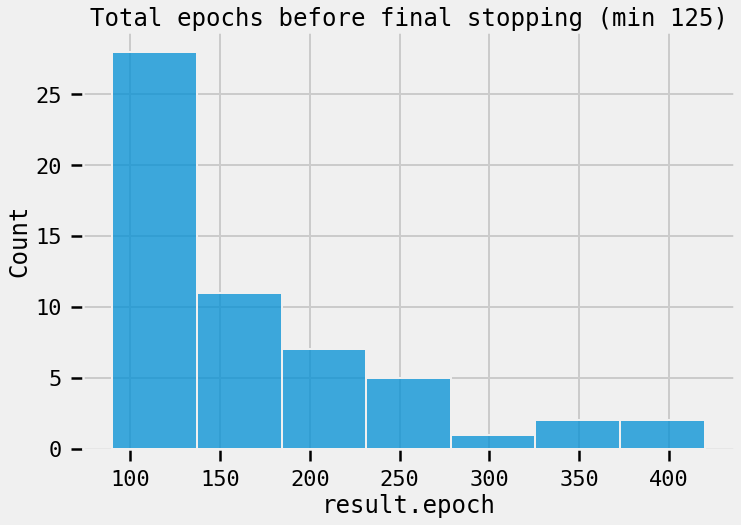

In [11]:
ax = sns.histplot(data=results_clean["result.epoch"].apply(max))
ax.set_title("Total epochs before final stopping (min 125)")

## Look at $r^2$ reconstruction

In [12]:
[c for c in results_clean.columns if 'pretrain' in c]

results_clean[["config.model.embedding.model", 'config.model.load_pretrained']]

,config.model.embedding.model,config.model.load_pretrained
0,rdkit,True
1,rdkit,True
2,rdkit,True
3,rdkit,True
4,rdkit,True
5,rdkit,True
6,rdkit,True
7,rdkit,True
8,rdkit,True
9,rdkit,True


### DE genes

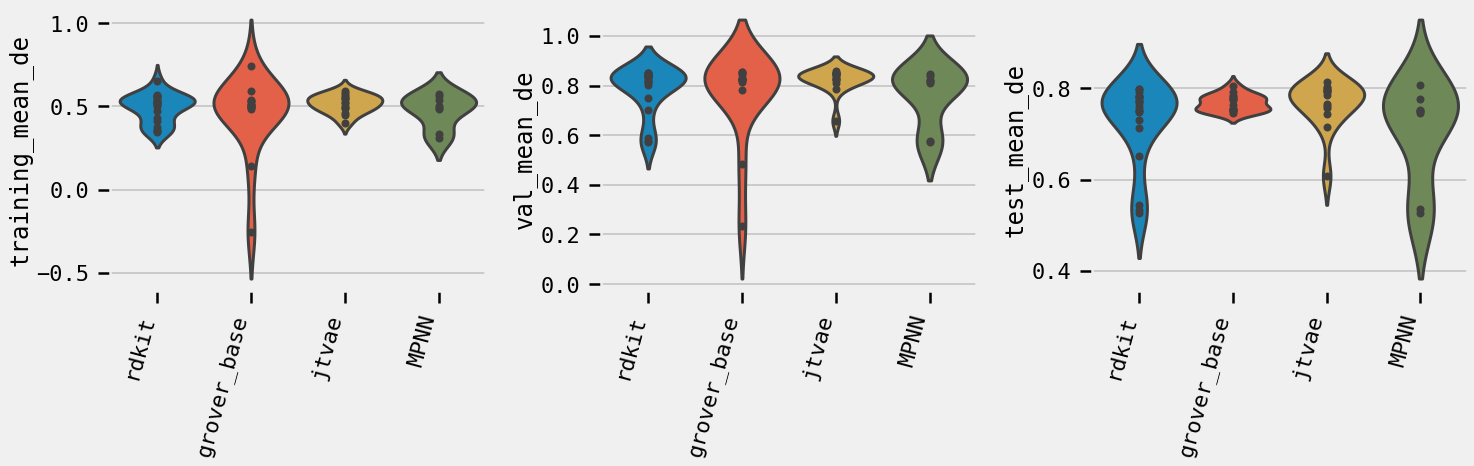

In [13]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean_de", "result.val_mean_de", "result.test_mean_de")):
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i], scale='width')
    # ax[i].set_ylim([0.39,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha="right")
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

### All genes

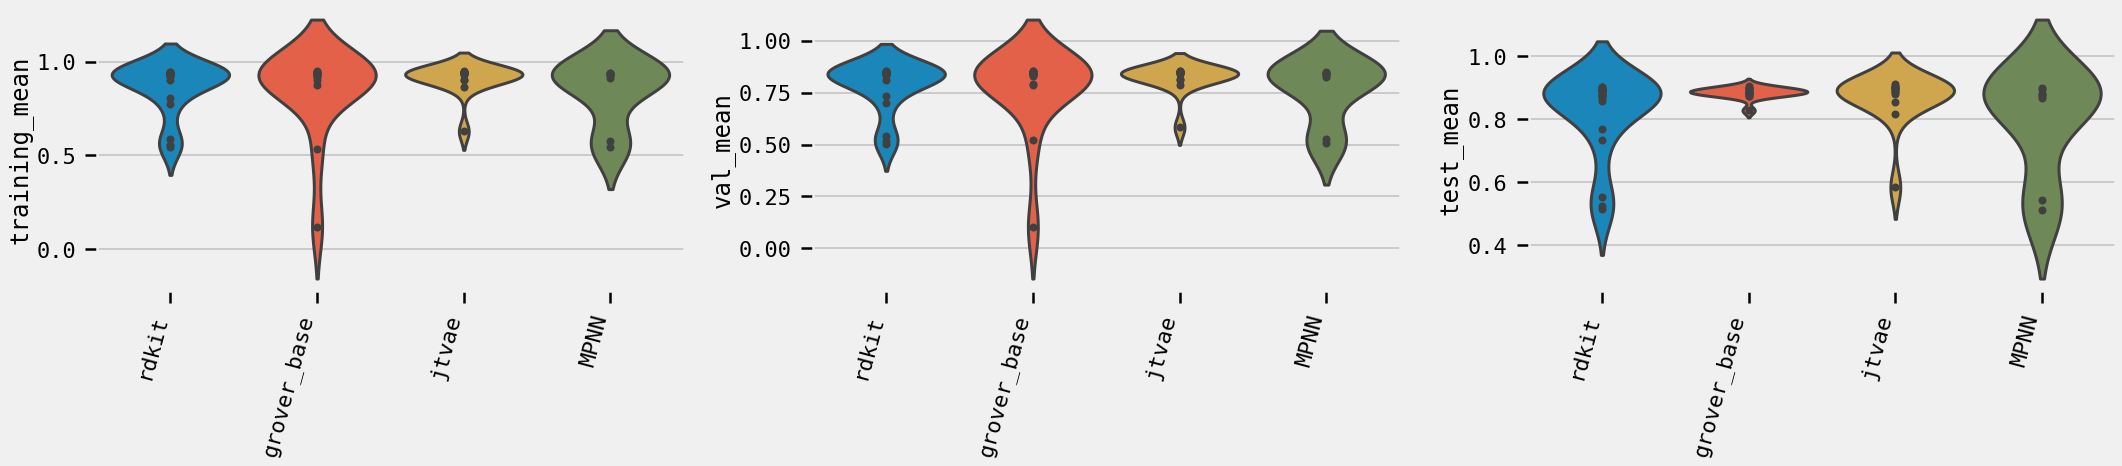

In [14]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean", "result.val_mean", "result.test_mean")):
    # sns.violinplot(data=results_clean[results_clean['config.model.load_pretrained']==True], x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i], scale='width')
    sns.violinplot(
        data=results_clean,
        x="config.model.embedding.model", 
        y=y, 
        # hue='config.model.load_pretrained',
        inner='point',
        ax=ax[i], 
        scale='width')
    # ax[i].set_ylim([0.82,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Look at disentanglement scores

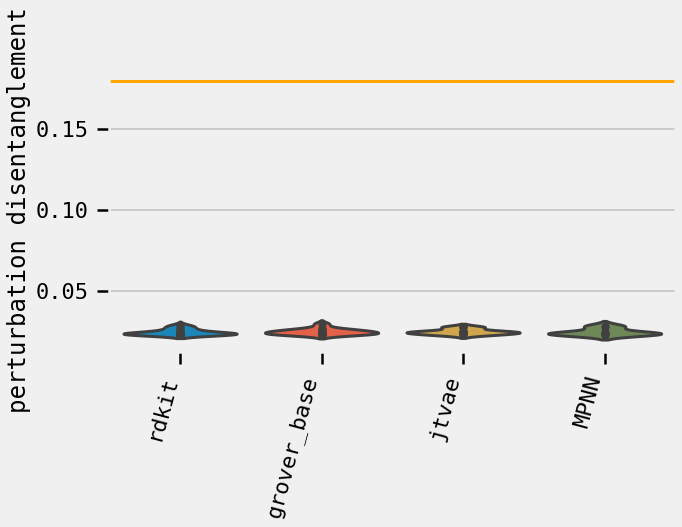

In [15]:
rows = 1 
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 7*rows), sharex=True)

for y in ["result.perturbation disentanglement"]:
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax, scale='width')
    # ax[i].set_ylim([0,1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right')
    ax.axhline(0.18, color='orange')
    ax.set_xlabel('')
    ax.set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Subselect to disentangled models

In [16]:
n_top = 5

performance_condition = lambda emb, pretrained, max_entangle: (results_clean["config.model.embedding.model"] == emb) & (results_clean["result.perturbation disentanglement"] < max_entangle) & (results_clean["config.model.load_pretrained"] == pretrained)

best = []
for embedding in list(results_clean["config.model.embedding.model"].unique()):
    for pretrained in [True, False]:
        df = results_clean[performance_condition(embedding, pretrained, 0.18)]
        print(embedding, pretrained, len(df))
        best.append(df.sort_values(by="result.val_mean_de", ascending=False).head(n_top))

best = pd.concat(best)

rdkit True 10
rdkit False 10
grover_base True 5
grover_base False 9
jtvae True 8
jtvae False 6
MPNN True 6
MPNN False 2


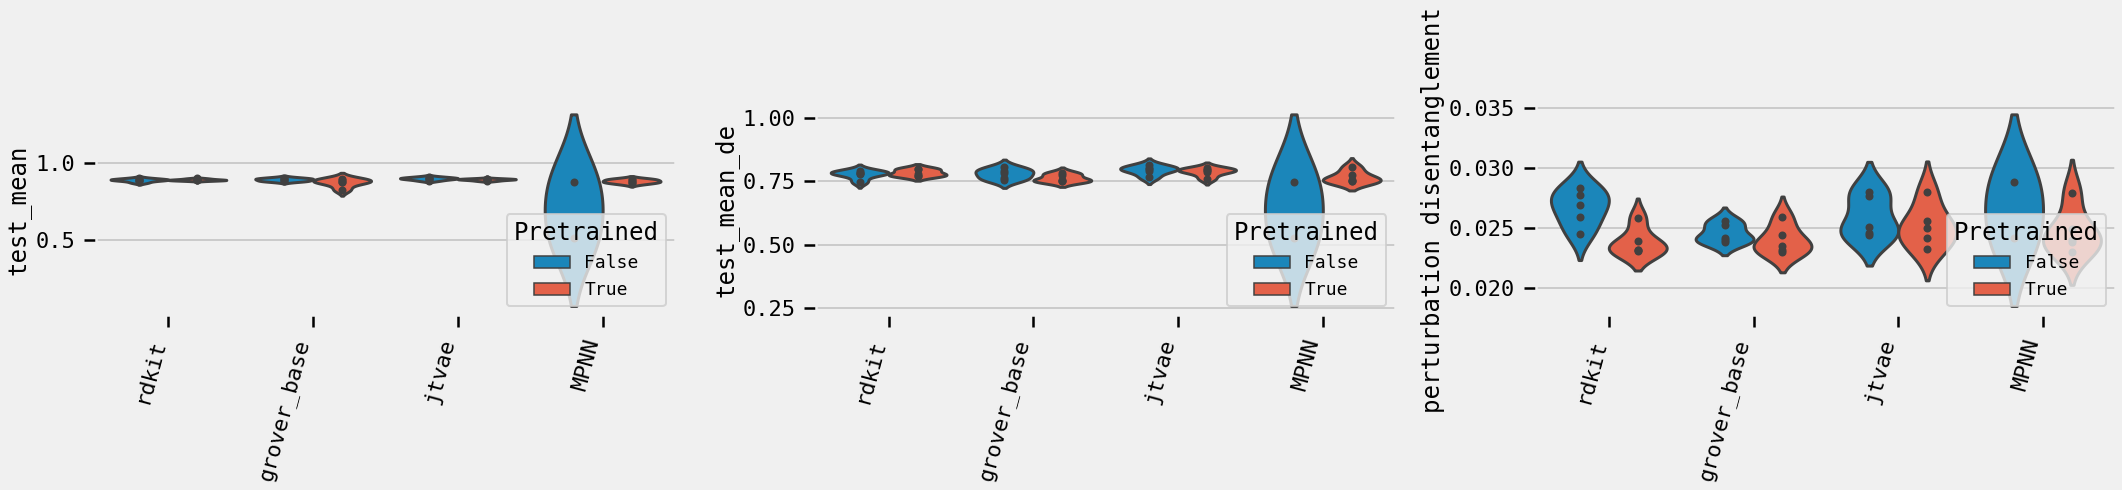

In [17]:
# All genes, DE genes, disentanglement
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.test_mean", "result.test_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)
plt.tight_layout()


## Take a deeper look in the `.config` of the best performing models

In [18]:
best[["config." + col for col in sweeped_params] +
     ["result.perturbation disentanglement", "result.test_mean", "result.test_mean_de"]]

,config.model.hparams.dim,config.model.hparams.dropout,config.model.hparams.dosers_width,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.autoencoder_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.adversary_width,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_wd,config.model.hparams.adversary_steps,config.model.hparams.reg_adversary,config.model.hparams.penalty_adversary,config.model.hparams.batch_size,config.model.hparams.step_size_lr,config.model.hparams.embedding_encoder_width,config.model.hparams.embedding_encoder_depth,result.perturbation disentanglement,result.test_mean,result.test_mean_de
0,32,0.262378,64,3,0.000561,1.329292e-07,256,4,0.000561,1.329292e-07,128,2,0.000364,7.459343e-07,3,15.355287,2.368864,64,50,128,4,0.023957,0.895001,0.798590
8,32,0.262378,64,3,0.001593,6.358359e-07,256,4,0.001593,6.358359e-07,128,3,0.001208,1.012920e-05,3,30.271829,3.991306,128,50,128,4,0.023137,0.901240,0.797712
3,32,0.262378,64,3,0.001575,6.251374e-07,256,4,0.001575,6.251374e-07,128,4,0.001193,9.846739e-06,3,30.049874,3.968793,64,50,128,4,0.025819,0.889893,0.772694
4,32,0.262378,64,3,0.000205,2.938028e-08,256,4,0.000205,2.938028e-08,128,3,0.000114,6.026889e-08,3,7.979119,1.432249,128,50,128,4,0.023219,0.891926,0.780230
5,32,0.262378,64,3,0.000205,2.937538e-08,256,4,0.000205,2.937538e-08,128,2,0.000114,6.025216e-08,2,7.978542,1.432170,128,50,128,4,0.023172,0.887906,0.771454
18,32,0.262378,64,3,0.001593,6.358359e-07,256,4,0.001593,6.358359e-07,128,3,0.001208,1.012920e-05,3,30.271829,3.991306,128,50,128,4,0.025924,0.902403,0.791730
15,32,0.262378,64,3,0.000205,2.937538e-08,256,4,0.000205,2.937538e-08,128,2,0.000114,6.025216e-08,2,7.978542,1.432170,128,50,128,4,0.028360,0.891505,0.779493
13,32,0.262378,64,3,0.001575,6.251374e-07,256,4,0.001575,6.251374e-07,128,4,0.001193,9.846739e-06,3,30.049874,3.968793,64,50,128,4,0.024542,0.893363,0.782344
10,32,0.262378,64,3,0.000561,1.329292e-07,256,4,0.000561,1.329292e-07,128,2,0.000364,7.459343e-07,3,15.355287,2.368864,64,50,128,4,0.026978,0.874979,0.748473
16,32,0.262378,64,3,0.000131,1.493657e-08,256,4,0.000131,1.493657e-08,128,4,0.000068,1.951722e-08,3,5.950295,1.143098,64,50,128,4,0.027739,0.891951,0.782826
